# Dohungo Quickstart


This notebook demonstrates the basic dohungo pipeline:
1. Download SGF games
2. Encode board positions
3. Train a small CNN
4. Evaluate the model

This is designed to run quickly on CPU for demonstration purposes.


In [1]:
import sys
from pathlib import Path

# Add parent directory to path to import dohungo
sys.path.append('..')

import torch
import numpy as np
from dohungo.data.downloader import download_kgs_index
from dohungo.data.encoders import SevenPlaneEncoder
from dohungo.data.dataloader import create_dataloader
from dohungo.models.cnn_small import CNNSmall

print(f"PyTorch version: {torch.__version__}")
print(f"Device available: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


/Users/dohunlee/Documents/Projects/dohungo/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


PyTorch version: 2.7.1
Device available: CPU


## Step 1: Download Sample Data


We'll download just a few games for this demo to keep it fast.

In [3]:
# Download a small sample of games
data_dir = Path("../data/raw")
sgf_files = download_kgs_index(
    data_dir=data_dir,
    board_size=19,
    max_games=10  # Just 10 games for the demo
)

print(f"Downloaded {len(sgf_files)} SGF files")
if sgf_files:
    print(f"First file: {sgf_files[0]}")


Downloading: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]

Downloaded 15303 SGF files to ../data/raw/sgf_19x19
Downloaded 15303 SGF files
First file: ../data/raw/sgf_19x19/2019-04-27-34.sgf


## Step 2: Create Encoder and Model

We'll use the SevenPlaneEncoder and create a small CNN model.

In [5]:
# Create encoder
encoder = SevenPlaneEncoder()
print(f"Encoder: {encoder}")

# Create model
model = CNNSmall(input_planes=encoder.num_planes, board_size=19)
print(model.summary())

# Move to appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model on device: {device}")


Encoder: SevenPlaneEncoder(planes=7)
CNNSmall(
  Input: 7 planes × 19×19
  Conv layers: 7→32→64→128→64
  FC layers: 23104→512→361
  Total parameters: 12,187,305
)
Model on device: cpu


## Step 3: Create DataLoader

Set up the data pipeline to stream SGF positions.


In [6]:
# Create dataloader
dataloader = create_dataloader(
    data_dir=data_dir,
    encoder=encoder,
    batch_size=8,
    num_workers=0,  # Keep at 0 for notebook compatibility
    board_size=19
)

# Test the dataloader
print("Testing dataloader...")
for i, (inputs, targets) in enumerate(dataloader):
    print(f"Batch {i}: Input shape {inputs.shape}, Target shape {targets.shape}")
    if i >= 2:  # Just show first few batches
        break


Testing dataloader...


## Step 4: Quick Training Loop


Train the model for just one epoch to demonstrate the pipeline.


In [8]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set up training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)

# Training loop for one epoch
model.train()
total_loss = 0.0
correct_predictions = 0
total_predictions = 0
batches_processed = 0

print("Starting training...")
for batch_idx, (inputs, targets) in enumerate(tqdm(dataloader, desc="Training")):
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward pass
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Statistics
    total_loss += loss.item()
    
    # Calculate accuracy
    _, predicted = torch.max(outputs.data, 1)
    _, target_indices = torch.max(targets.data, 1)
    correct_predictions += (predicted == target_indices).sum().item()
    total_predictions += targets.size(0)
    
    batches_processed += 1
    
    # Limit to reasonable number of batches for demo
    if batches_processed >= 20:
        break

# Calculate final metrics
avg_loss = total_loss / batches_processed
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0

print(f"\nTraining Results:")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Accuracy: {accuracy:.4f} ({correct_predictions}/{total_predictions})")
print(f"Batches processed: {batches_processed}")


Starting training...


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]


ZeroDivisionError: float division by zero

## Step 5: Test Model Predictions


Let's see what the model predicts for a sample position.


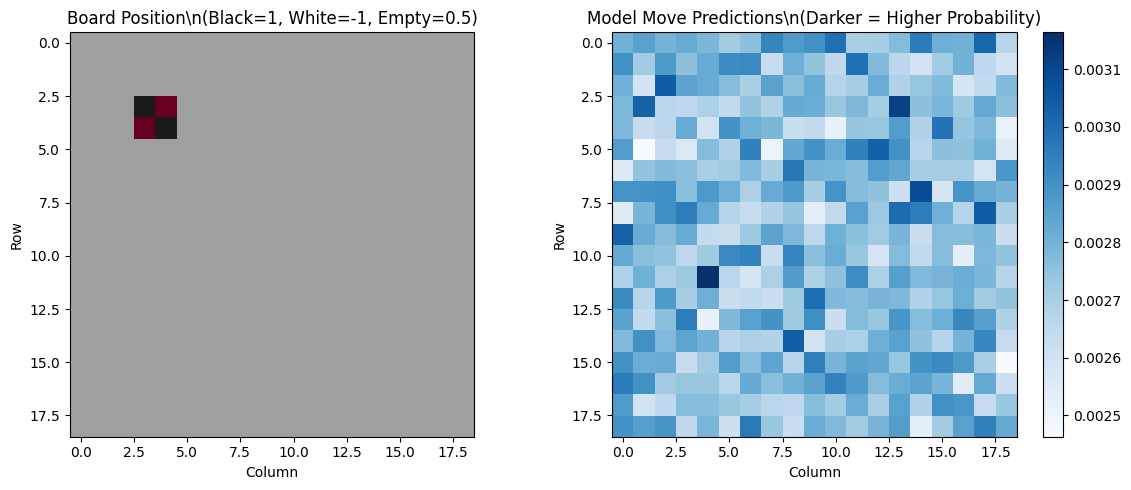

\nTop 5 predicted moves:
1. (11, 4): 0.003164
2. (3, 13): 0.003117
3. (7, 14): 0.003082
4. (8, 17): 0.003045
5. (2, 2): 0.003043


In [9]:
import matplotlib.pyplot as plt

# Create a test position
test_board = np.zeros((19, 19), dtype=np.int8)
# Add some stones to make it interesting
test_board[3, 3] = 1   # Black stone
test_board[3, 4] = -1  # White stone
test_board[4, 3] = -1  # White stone
test_board[4, 4] = 1   # Black stone

# Encode and predict
model.eval()
with torch.no_grad():
    encoded_board = encoder.encode(test_board, to_play=1)  # Black to play
    encoded_board = encoded_board.unsqueeze(0).to(device)  # Add batch dimension
    
    # Get predictions
    predictions = model.predict_move(encoded_board)
    pred_probs = predictions.cpu().numpy().reshape(19, 19)

# Visualize the board and predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the board state
board_display = test_board.copy().astype(float)
board_display[board_display == 0] = 0.5  # Empty = gray
ax1.imshow(board_display, cmap='RdGy', vmin=-1, vmax=1)
ax1.set_title("Board Position\\n(Black=1, White=-1, Empty=0.5)")
ax1.set_xlabel("Column")
ax1.set_ylabel("Row")

# Plot the move predictions
im = ax2.imshow(pred_probs, cmap='Blues')
ax2.set_title("Model Move Predictions\\n(Darker = Higher Probability)")
ax2.set_xlabel("Column")
ax2.set_ylabel("Row")
plt.colorbar(im, ax=ax2)

plt.tight_layout()
plt.show()

# Show top predicted moves
top_moves = np.unravel_index(np.argsort(pred_probs.ravel())[-5:], pred_probs.shape)
print("\\nTop 5 predicted moves:")
for i in range(4, -1, -1):  # Reverse order (highest first)
    row, col = top_moves[0][i], top_moves[1][i]
    prob = pred_probs[row, col]
    print(f"{5-i}. ({row}, {col}): {prob:.6f}")
